In [1]:
# Importing dependencies (for now)

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Explore the data

In [6]:
data = pd.read_csv('./data/data.csv')
data.head(5)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
data = data.drop('Unnamed: 0', axis = 1)

In [9]:
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [10]:
classes = data['status'].unique()
classes

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [26]:
filtered_classes = {}
for cls in classes:
    filtered_classes[cls] = len(data[data['status'] == cls])

In [27]:
filtered_classes

{'Anxiety': 3888,
 'Normal': 16351,
 'Depression': 15404,
 'Suicidal': 10653,
 'Stress': 2669,
 'Bipolar': 2877,
 'Personality disorder': 1201}

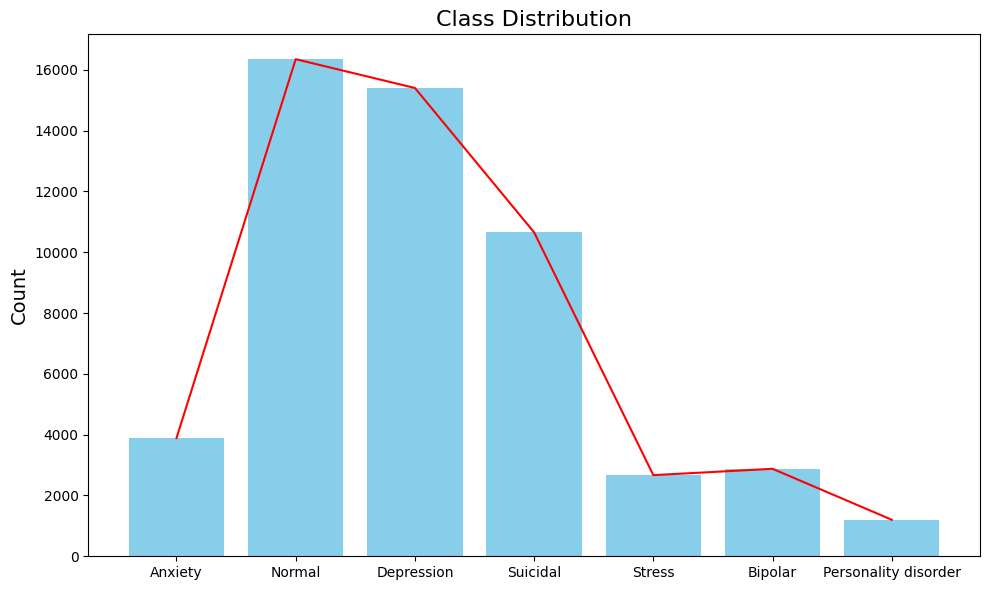

In [37]:
counts = list(filtered_classes.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.plot(classes, counts, color = 'red')
plt.title('Class Distribution', fontsize=16)

plt.ylabel('Count', fontsize=14)



plt.tight_layout()
plt.show()